# Implementing PDF table recognition and extraction of data
Based on https://nanonets.com/blog/table-extraction-deep-learning/

Also see https://nanonets.com/blog/ocr-with-tesseract/

## Uses:
- pdf2image for converting PDF pages to images (once I implement it; should be trivial)
- OpenCV for finding blocks on the page (and possibly more, I don't know yet)
- Numpy because numbers, and probably pandas along the way.
- Tesseract for OCR (once I implement it)
"""

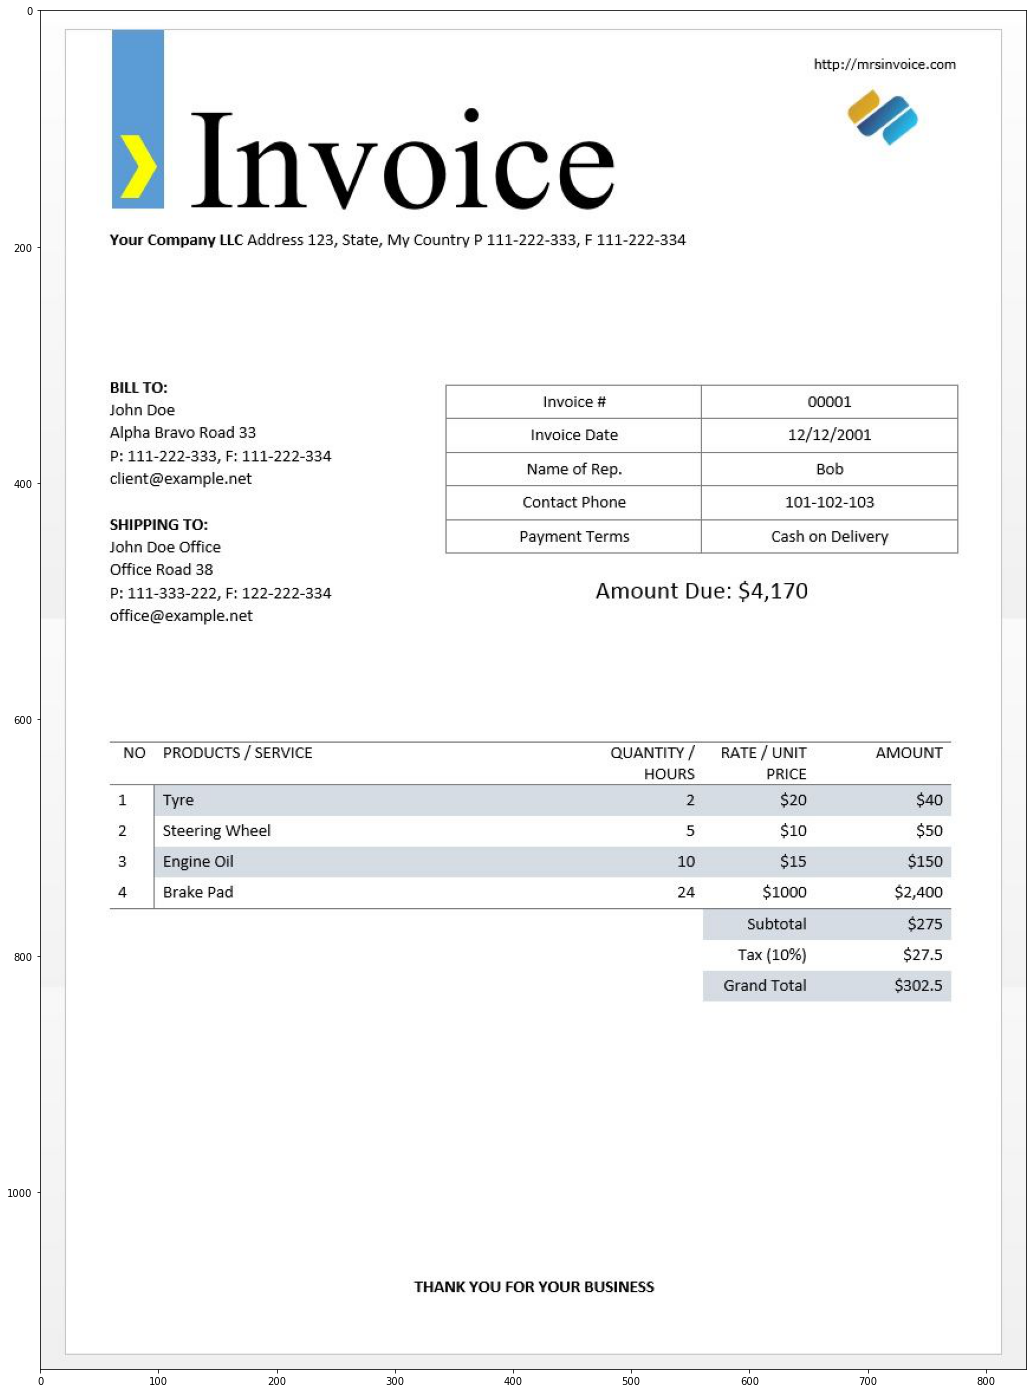

In [86]:
from matplotlib import pyplot as plot
import numpy as np
import pandas as pd
import cv2
from IPython.display import Image, HTML
testFile = "pdftables.pdf"
sampeleTable = "tablesample.png"
sampleInvoice = "tablesample2.jpg"
previewSize = (40,25)
inputImage = cv2.imread(sampleInvoice)

# OPENCV WORKS WITH BGR INSTEAD OF RGB BY DEFAULT. WE THEREFORE CONVERT IT TO MATCH EXPECTED BEHAVIOUR...
inputImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2RGB) 

# We make a copy of the image in grayscale to be used for finding contours...
inputContour = cv2.cvtColor(inputImage, cv2.COLOR_RGB2GRAY)

# Displaying our input image...
plot.figure(figsize=previewSize)
plot.imshow(inputImage)

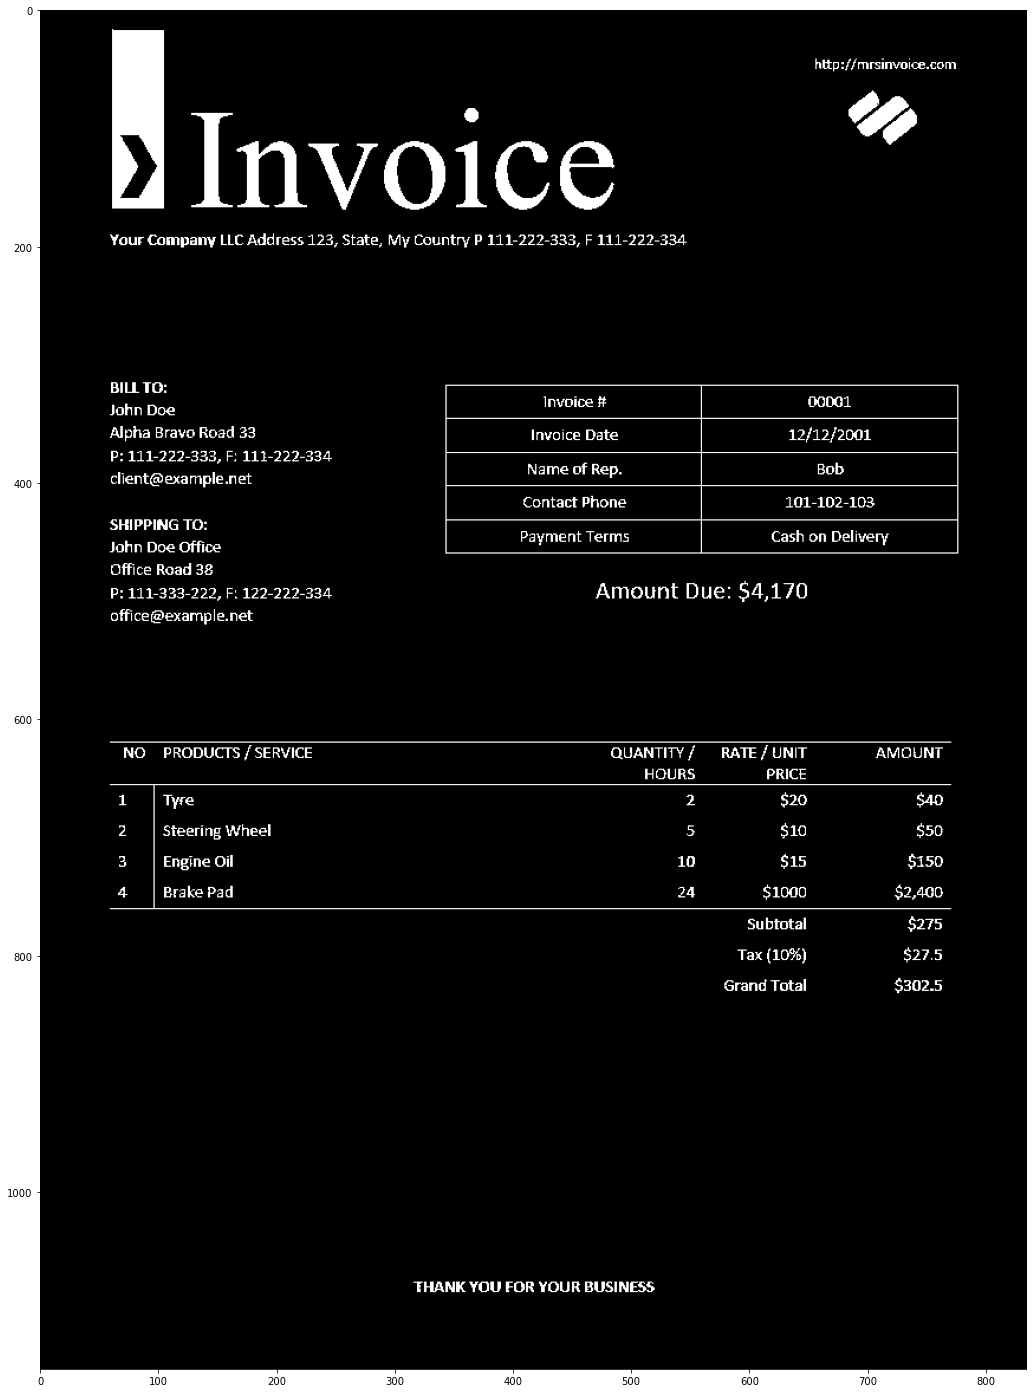

In [87]:
"""
Thresholding kinda takes the min and max values (respectively 180 and 255) and compares pixels near them and if the pixel's value (rgb-defined, 0 to 255) is in-between the given values, it groups it along other similar neihgbouring pixels...

"Hey pixel, you look like me, I think we should band together with others who look like us." -- the pixels to each others, probably
"""
ret, threshold_value = cv2.threshold(inputContour, 180, 255, cv2.THRESH_BINARY_INV)
# Displaying the current result...
plot.figure(figsize=previewSize)
plot.imshow(threshold_value)

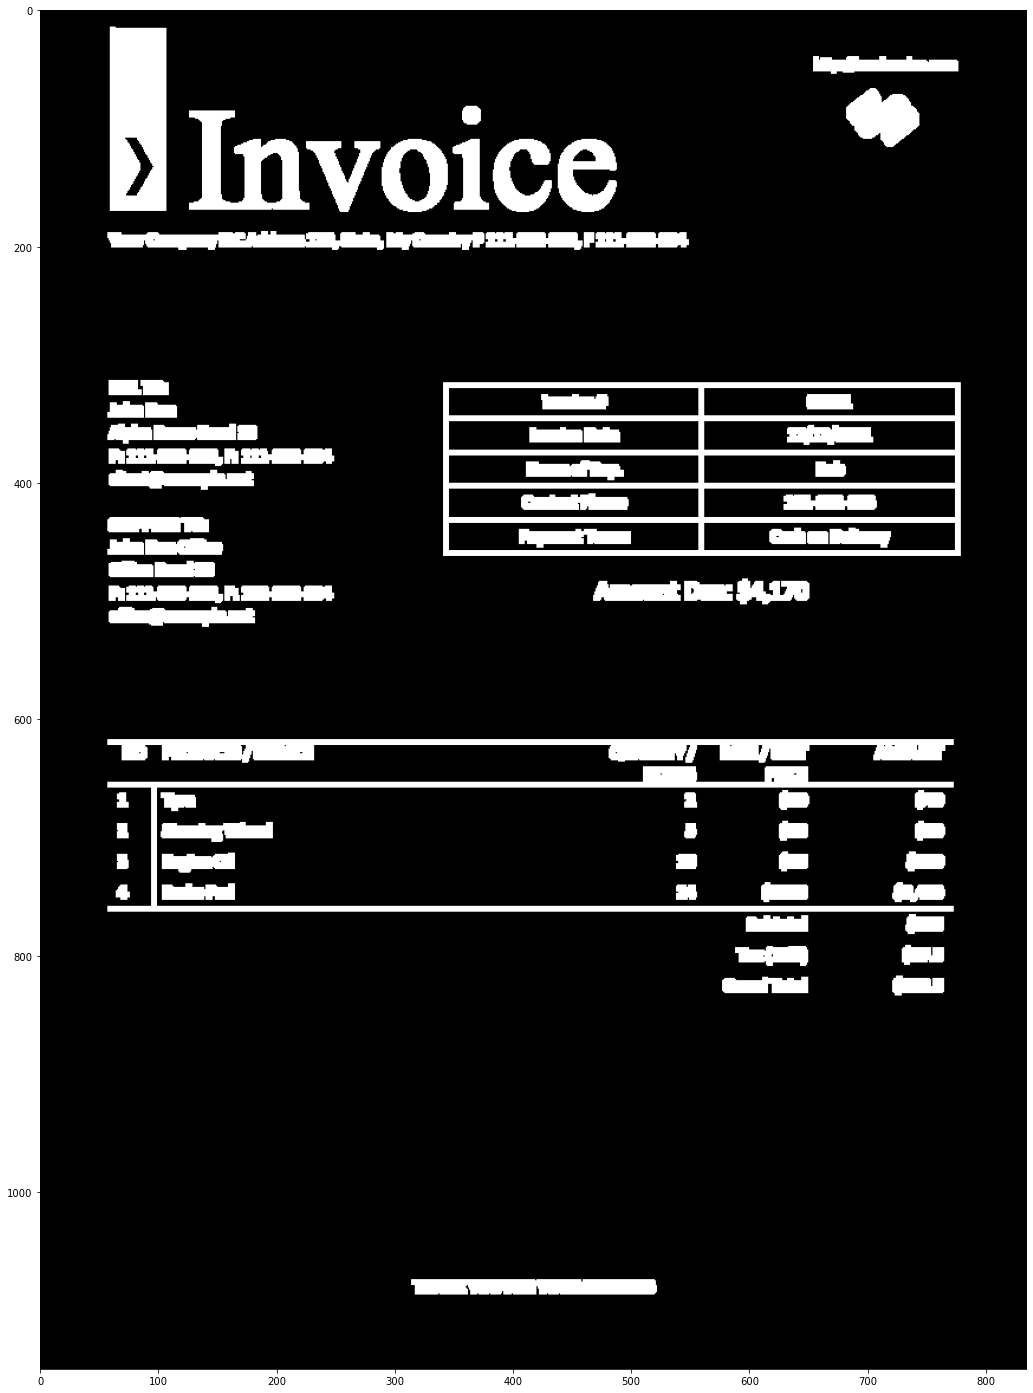

In [88]:
# Detailed explainations of what's happening: https://towardsdatascience.com/basics-of-kernels-and-convolutions-with-opencv-c15311ab8f55
# kernel here means a matrix, here 5 by 5
kernel = np.ones((5,5), np.uint8)
# cv2.dilate makes what's called a convolution, which finds nearest neihgbours (nearest similar pixels in this case)... makes things fat, basically.
# The bigger the kernel, the more sensitive the convolution will be and the more neighbouring pixels it will find (too much or too little isn't good)
# We run it only once (iterations=1)
# It's probably part of the process used for blurring a picture in Photoshop or the likes...
dilated_value = cv2.dilate(threshold_value, kernel, iterations=1)
# Displaying the current result...
plot.figure(figsize=previewSize)
plot.imshow(dilated_value)

In [89]:
# Finds contours...
contours, hierarchy = cv2.findContours(dilated_value, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [90]:
# Looping through contours found by OpenCV and drawing them on our pict
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour) # the cv2.boundingRect function returns a position (x,y) and size (w,h) as a series...
    # painting boundaries (in rgb(255,0,0) red)
    inputImage = cv2.rectangle(inputImage, (x,y), (x+w,y+h), (255,0,0), 1)

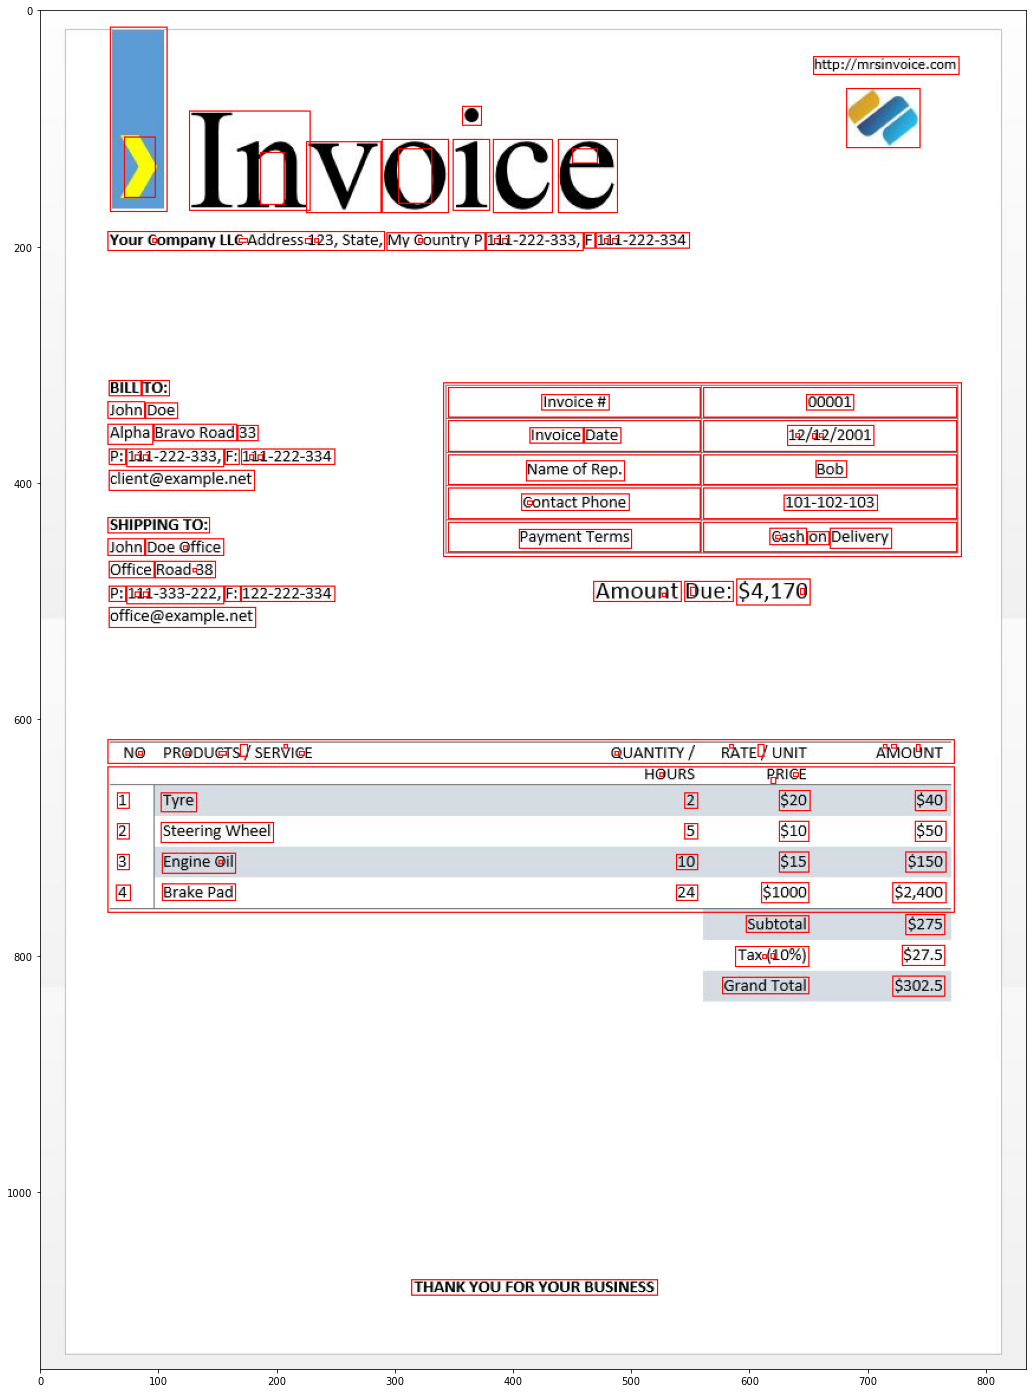

In [91]:
# Displaying the result...
plot.figure(figsize=previewSize)
plot.imshow(inputImage)
plot.show()
# cv2.namedWindow("detectable", cv2.WINDOW_NORMAL)

# What's next?
Technically, the computer has no idea what it just drew boxes around. These boxes are drawn from the contours, but they can act as regions to delimit where to look for data using OCR.

To easily find tables based on this (when it has actual, visible borders), I'd first try to look for boxes that have one or more boxes inside them, and if there are similar boxes (with boxes inside them) around them. In theory, we could group them and tell call such a group a table. This method would work easier on the invoice information table on the top right in the current example. 

However, we can see the table with actual data down in the example presents three issues:
- It excludes the *Subtotal*, *Tax* and *Grand Total* lines (no contour around them) yet finds data boxes;
- It didn't accurately identify columns in the header;
- It cut the header after one line instead of its two actual lines, which implies our threshold might be too high for this particular table; 